<a href="https://colab.research.google.com/github/christoph-fraller/dopp_2020w_group03_ex3/blob/main/dopp_2020w_group03_ex3_with_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate SSH-Keys for Accessing Git Repository

In [ ]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# generate ssh keys (insert your username@github.com + hit enter when prompted for any answer)
! ssh-keygen -t rsa -b 4096 -C 'michaelstitz@github.com'

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256://o6Tt7w9QoDHX0sEGZIX/GpE7DFeE5RCEPO7ZBOFGU michaelstitz@github.com
The key's randomart image is:
+---[RSA 4096]----+
|         .oO@E*o |
|          ==OO o.|
|           B*oo.+|
|          o.oooo |
|        S ...+   |
|         . .  .  |
|          + o .  |
|         o.= + . |
|         .=== ...|
+----[SHA256]-----+


In [ ]:
# check whether or not the ssh keys have been created ('id_rsa' and 'id_rsa.pub' should be displayed)
! ls /root/.ssh/

id_rsa	id_rsa.pub


In [ ]:
# create directory for saving the ssh keys
! mkdir -p /content/drive/MyDrive/Ssh

In [ ]:
# copy ssh keys from /root/.ssh/* to /content/drive/MyDrive/Ssh/*
! cp /root/.ssh/id_rsa /content/drive/MyDrive/Ssh/
! cp /root/.ssh/id_rsa.pub /content/drive/MyDrive/Ssh/

In [ ]:
# display public ssh key for copy/paste
! cat /content/drive/MyDrive/Ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDPd8zpuwQEJtEnd4wmZj+1QWgwwRURyzYGVDaw/Bk72NNBL65S+Ia4EGmvCmNy5Px0xCiZ5N+zF8G+8xY5lxx23pug8DdDppfpLaeDaxT9NJb8K0YQosvQTGc03gme1HhcbgObpRYyAwRJi/YsTyXCrbfG9awA2mi6ZVqIWncCE0GmqVJ0Rjs8lOf72kv0PK4v+YbfkIiDBUB4dSZ7niN6KcDb123bLzCpBv3GS4aR82CI3nA8PSrdp3n474zLQp/fllwS1yUD0HOPc2vHslP54COWNqubtaApgSi6F9QNRmrzG+zOI0pDigNAFwvKiCd6RAFSm0i9cjftl05Ee7302onXsrtHxM+Ta7TQ7rxn48fOh8FZNC0EHC1qXdc5y7hrbprdEj6msWJz/sUSv0HpRbt+mma9x6zwv87bgPVC8S6MubWvPzgS3/9x6vTa2oCb7dtj61XjTu1uU2tzck4aCZW6VoaAUrKNf19r7ORbZ+Sa7A6AdTNRL6EmHdHOLAUv+oFHXgOu8gbE7s8lGqPg3AtHvEy7Sr8qP+5st/wc9Cb8hdEcr94x/Y+EJ9Ic1m1FtKyJz3Os7Mbss4nVMclb0Gav0I82jDkf/v2rpB1q4Wygg73pz4ONFuYLQGfHeFcsSyZNCnc9/9KNEW/jsA+IDADvXcooFzVgcGGtNo6VGw== michaelstitz@github.com


In [ ]:
# add github to known hosts and adapt file access permissions
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
! chmod 600 /root/.ssh/id_rsa
! ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
git@github.com: Permission denied (publickey).


# Git Setup

In [ ]:
# git config settings (replace with your credentials)
! git config --global user.email "michaelstitz@gmail.com"
! git config --global user.name "michaelstitz"

In [ ]:
# create directory for git repositories
! mkdir -p /content/drive/MyDrive/Git

In [ ]:
# git-clone has to be performed only once when setting up the git repo at your google drive
! git clone git@github.com:christoph-fraller/dopp_2020w_group03_ex3.git /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

Cloning into '/content/drive/MyDrive/Git/dopp_2020w_group03_ex3'...
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


## Important Shell and Git Commands

**NOTICE:** Always ensure that you are in the right directory when performing git commands (e.g. /content/drive/MyDrive/Git/dopp_2020w_group03_ex3). In case of any issues that might occur when switching directories it is highly recommended to restart the runtime engine (CTRL + M + .).

In [ ]:
# check current working directory
! pwd

/content


In [ ]:
# switch to specified working directory
%cd /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

[Errno 2] No such file or directory: '/content/drive/MyDrive/Git/dopp_2020w_group03_ex3'
/content


In [ ]:
# list content of current working directory
! ls

sample_data


In [ ]:
# check git status
! git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# always perform a git pull before you start working or commit/push some changes
! git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# add a new data file to git repo directly from colab
# at first upload the file into the folder of your google drive
# ! git add data/world_bank_income_level_thresholds.csv
# ! git commit -m 'New file added.'
# ! git push

[main 5f5e270] New file added.
Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.20 KiB | 307.00 KiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), done.
To github.com:christoph-fraller/dopp_2020w_group03_ex3.git
   3e96cae..5f5e270  main -> main


# Geopanda installation

In [1]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 

# Perform these steps everytime when a new session has been started

In [2]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# create directory
! mkdir -p /root/.ssh

In [4]:
# copy ssh keys from /content/drive/MyDrive/Ssh/* to /root/.ssh/*
! cp /content/drive/MyDrive/Ssh/id_rsa /root/.ssh/
! cp /content/drive/MyDrive/Ssh/id_rsa.pub /root/.ssh/ 

In [5]:
# add github to known hosts and adapt file access permissions
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts
! chmod 600 /root/.ssh/id_rsa
! ssh -T git@github.com

# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
# github.com:22 SSH-2.0-babeld-78794f53
Hi christoph-fraller/dopp_2020w_group03_ex3! You've successfully authenticated, but GitHub does not provide shell access.


In [6]:
# switch to specified working directory
%cd /content/drive/MyDrive/Git/dopp_2020w_group03_ex3

/content/drive/MyDrive/Git/dopp_2020w_group03_ex3


In [7]:
# always perform a git pull before you start working or commit/push some changes
! git pull

Already up to date.


In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas

# Data Preprocessing

###Load and merge income data


In [66]:
# load income data from csv
income_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/undata_gni_per_capita.csv', sep = ';')

# extend income data by adding an entry for each combination of (calendar_year, country_code) due to there are no missing entries in the data
country_data_list = income_data[['country_code', 'country_name']].drop_duplicates().values.tolist()
output_list = []
for lst in country_data_list:
    country_code = lst[0]
    country_name = lst[1]
    for calendar_year in range(1970, 2020):
      output_list.append([calendar_year, country_code, country_name])
df = pd.DataFrame(output_list, columns = ['calendar_year', 'country_code', 'country_name'])
income_data_complete = df.merge(income_data[['calendar_year', 'country_code', 'gni_per_capita_us_dollar']], how = 'left', on = ['calendar_year', 'country_code'])

# load population data from csv
population_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/undata_population_total.csv', sep = ';', 
                              usecols = ['country_code', 'calendar_year', 'population_total'])
population_data.drop_duplicates(inplace = True)
population_data['population_total'] = population_data['population_total'] * 1000 # total population is specified in 1000

# load country codes from csv
country_codes = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/iso3166_unsd_country_codes.csv', sep = ';', 
                            usecols = ['m49_code', 'iso_alpha2_code', 'iso_alpha3_code'])

# merge income with population data and country codes
merged_income_data = income_data_complete.merge(population_data, how = 'left', on = ['calendar_year', 'country_code'])
merged_income_data = merged_income_data.merge(country_codes, how = 'left', left_on = 'country_code', right_on = 'm49_code')

merged_income_data.drop(['country_code'], axis = 1, inplace = True)
merged_income_data.rename(columns = {'country_code': 'm49_code'}, inplace = True)
merged_income_data = merged_income_data[['calendar_year', 'iso_alpha3_code', 'iso_alpha2_code', 'm49_code', 'country_name', 'population_total', 'gni_per_capita_us_dollar']] 

merged_income_data.tail()

,calendar_year,iso_alpha3_code,iso_alpha2_code,m49_code,country_name,population_total,gni_per_capita_us_dollar
10995,2015,ZWE,ZW,716.0,Zimbabwe,13814629.0,1301.574535
10996,2016,ZWE,ZW,716.0,Zimbabwe,14030331.0,1338.026334
10997,2017,ZWE,ZW,716.0,Zimbabwe,14236595.0,1410.421297
10998,2018,ZWE,ZW,716.0,Zimbabwe,14438802.0,1572.613043
10999,2019,ZWE,ZW,716.0,Zimbabwe,14645468.0,NaN


## Handling of missing values in country-specific data

['Former Czechoslovakia',
 'Former Ethiopia',
 'Former Netherlands Antilles',
 'Former Sudan',
 'Former USSR',
 'Former Yugoslavia',
 'Kosovo',
 'Namibia',
 'United Republic of Tanzania: Mainland',
 'United Republic of Tanzania: Zanzibar',
 'Yemen: Former Democratic Yemen',
 'Yemen: Former Yemen Arab Republic']

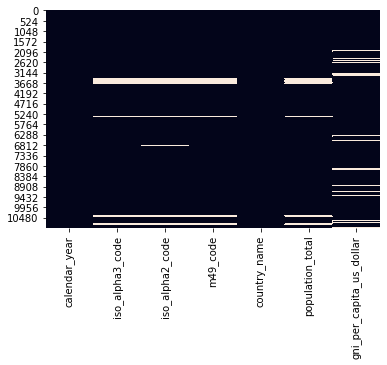

In [67]:
# get an overview of missing values in income data
sb.heatmap(merged_income_data.isna(), cbar = False);

# it seems there is pattern between the missing values of the columns iso_alpha3_code, iso_alpha2_code, m49_code and population_total
merged_income_data.loc[merged_income_data['iso_alpha2_code'].isna()].country_name.unique().tolist()

In [68]:
def handle_missing_country_codes(input_data):

    df = pd.DataFrame(input_data)

    country_codes_list = ['iso_alpha3_code', 'iso_alpha2_code', 'm49_code']   

    # Kosovo has declared its independence from Serbia in 2008 but until today this declaration is quite controversial.
    # Due to reasons of simplicity and without being politically, we have decided to exclude the Kosovo from our analysis.
    df.drop(df[df['country_name'] == 'Kosovo'].index, inplace = True)
    df.reset_index(drop = True, inplace = True)

    # load formerly used country codes from csv
    former_country_codes = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/iso3166_formerly_used_country_codes.csv', sep = ';', na_filter = False)

    # insert missing values
    for row_index in range(0, len(df)):
      
      for country_code in country_codes_list:
        
        # check if country code value is missing
        if(pd.isnull(df.loc[row_index, country_code])):
          
          # insert missing missing country code
          df.loc[row_index, country_code] = former_country_codes.loc[former_country_codes[former_country_codes['country_name'] == df.loc[row_index, 'country_name']].index[0], country_code]

    return df
    
cleaned_income_data = handle_missing_country_codes(merged_income_data)

[]

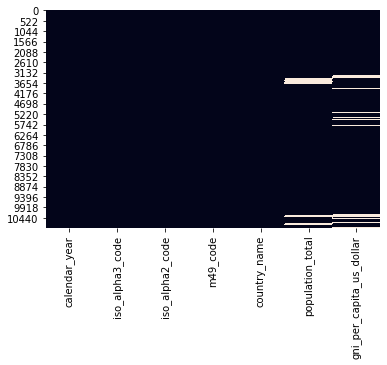

In [65]:
# get an overview of missing values in income data
sb.heatmap(cleaned_income_data.isna(), cbar = False);

# it seems there is pattern between the missing values of the columns iso_alpha3_code, iso_alpha2_code, m49_code and population_total
cleaned_income_data.loc[cleaned_income_data['iso_alpha2_code'].isna()].country_name.unique().tolist()

In [69]:
cleaned_income_data.loc[cleaned_income_data['country_name'] == 'Namibia']

,calendar_year,iso_alpha3_code,iso_alpha2_code,m49_code,country_name,population_total,gni_per_capita_us_dollar
6800,1970,NAM,NA,516,Namibia,817469.0,611.181604
6801,1971,NAM,NA,516,Namibia,842354.0,663.170340
6802,1972,NAM,NA,516,Namibia,868958.0,644.262738
6803,1973,NAM,NA,516,Namibia,896266.0,792.325665
6804,1974,NAM,NA,516,Namibia,922903.0,939.557139
6805,1975,NAM,NA,516,Namibia,947921.0,969.303690
6806,1976,NAM,NA,516,Namibia,971121.0,916.886966
6807,1977,NAM,NA,516,Namibia,992956.0,996.030631
6808,1978,NAM,NA,516,Namibia,1014057.0,1125.839250
6809,1979,NAM,NA,516,Namibia,1035381.0,1354.023618


## Load thresholds and sdr deflators


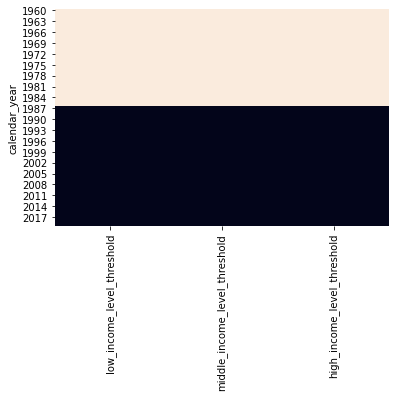

In [ ]:
# load income-level thresholds
income_threshold_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/world_bank_income_level_thresholds.csv', sep = ',')
income_threshold_data.drop(['banks_fiscal_year'], axis = 1, inplace = True)

# load sdr deflator values
sdr_deflator_data = pd.read_csv('/content/drive/MyDrive/Git/dopp_2020w_group03_ex3/data/world_bank_sdr_deflator.csv', sep = ',')
sdr_deflator_data.drop(['sdr_deflator_us_dollar'], axis = 1, inplace = True)

# create index on calendar_year
income_threshold_data.set_index(['calendar_year'], inplace = True)
sdr_deflator_data.set_index(['calendar_year'], inplace = True)

# merge income_threshold_data and sdr_deflator_data using index 'calendar_year'
threshold_data = income_threshold_data.merge(sdr_deflator_data, how = 'inner', left_index = True, right_index = True)

# visualize missing threshold values using a heatmap
sb.heatmap(threshold_data[['low_income_level_threshold', 'middle_income_level_threshold', 'high_income_level_threshold']].isna(), cbar = False);

## Calculate missing thresholds using sdr deflators


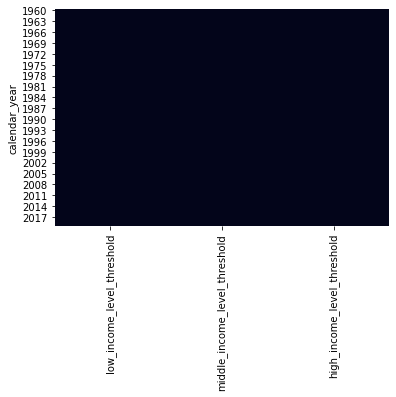

In [ ]:
def calculate_missing_thresholds(input_data):
    
    df = pd.DataFrame(input_data)
    
    thresholds_list = ['low_income_level_threshold', 'middle_income_level_threshold', 'high_income_level_threshold']   
    
    # calculate missing values
    for i in range(0, len(df)):
      
      # retrieve current index
      curr_index = df.index.max() - i
      for threshold in thresholds_list:
        
        # check if threshold value is missing
        if(np.isnan(df.loc[curr_index, threshold])):
          
          # calculate missing threshold value based on existing threshold and sdr_inflation_rate_annual_change
          df.loc[curr_index, threshold] = df.loc[curr_index + 1, threshold] / (100 + df.loc[curr_index + 1, 'sdr_inflation_rate_annual_change']) * 100
    
    # round thresholds to nearest multiple of base
    base = 5
    for threshold in thresholds_list:
      df[threshold] = round(df[threshold] / base) * base

    return df[thresholds_list]

threshold_data_complete = calculate_missing_thresholds(threshold_data)

# check whether or not all missing values have been replaced
sb.heatmap(threshold_data_complete.isna(), cbar = False);

## Assign income-level labels based on gni and income-level thresholds

In [ ]:
# merge merged_income_data and threshold_data_complete using calendar_year
income_classification_data = merged_income_data.merge(threshold_data_complete, how = 'left', on = 'calendar_year')

# assign income-level labels based on gni and thresholds
income_classification_data.loc[(income_classification_data['gni_per_capita_us_dollar'] <= income_classification_data['low_income_level_threshold']), 'income_level_label'] = 'low_income'
income_classification_data.loc[((income_classification_data['gni_per_capita_us_dollar'] > income_classification_data['low_income_level_threshold']) & 
                        (income_classification_data['gni_per_capita_us_dollar'] <= income_classification_data['middle_income_level_threshold'])), 'income_level_label'] = 'lower_middle_income'
income_classification_data.loc[((income_classification_data['gni_per_capita_us_dollar'] > income_classification_data['middle_income_level_threshold']) & 
                        (income_classification_data['gni_per_capita_us_dollar'] <= income_classification_data['high_income_level_threshold'])), 'income_level_label'] = 'upper_middle_income'
income_classification_data.loc[(income_classification_data['gni_per_capita_us_dollar'] > income_classification_data['high_income_level_threshold']), 'income_level_label'] = 'high_income'

# create index on calendar_year and iso_alpha3_code
#income_classification_data.reset_index(inplace = True)
#income_classification_data.set_index(['calendar_year', 'iso_alpha3_code'], inplace = True)

income_classification_data.tail()

,iso_alpha3_code,iso_alpha2_code,m49_code,country_name,population_total,gni_per_capita_us_dollar,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold,income_level_label
calendar_year,,,,,,,,,,
2014,ZWE,ZW,716.0,Zimbabwe,13586707.0,1298.569589,1045.0,4125.0,12735.0,lower_middle_income
2015,ZWE,ZW,716.0,Zimbabwe,13814629.0,1301.574535,1025.0,4035.0,12475.0,lower_middle_income
2016,ZWE,ZW,716.0,Zimbabwe,14030331.0,1338.026334,1005.0,3955.0,12235.0,lower_middle_income
2017,ZWE,ZW,716.0,Zimbabwe,14236595.0,1410.421297,995.0,3895.0,12055.0,lower_middle_income
2018,ZWE,ZW,716.0,Zimbabwe,14438802.0,1572.613043,1025.0,3995.0,12375.0,lower_middle_income


## Handling of missing values

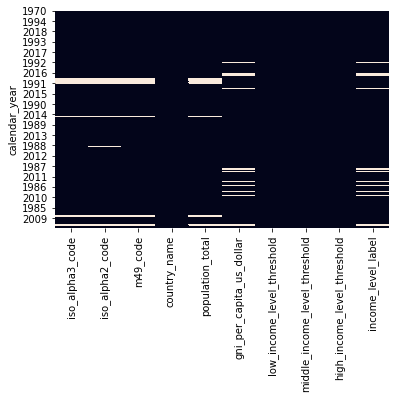

In [ ]:
sb.heatmap(income_classification_data.isna(), cbar = False);
#income_classification_data.loc[income_classification_data['iso_alpha3_code'].isna()].country_name.unique()
#income_classification_data.groupby(['iso_alpha3_code', 'country_name']).population_total.max()
#income_classification_data.loc[income_classification_data['country_name'] == 'Former Yugoslavia']
#income_classification_data.loc[income_classification_data['country_name'].isna()]

In [ ]:
# counts the number of missing values (years) in gni data (population_total only placeholder in that line)
income_classification_data.loc[income_classification_data['gni_per_capita_us_dollar'].isna()].groupby('country_name').count()

# Armenia became independent in 1991, formerly USSR
# Azerbaijan became independent in 1991, formerly USSR
# Belarus became independent in 1991, formerly USSR
# Bosnia and Herzegovina became independent in 1992, formerly Yugoslavia
# Croatia became independent in 1991, formerly Yugoslavia
# Curaçao ???
# Czech Republic became independent in 1993, formerly Czechoslovakia
# Eritrea became independent in 1993, formerly Ethiopia
# Estonia became independent in 1991, formerly USSR
# Ethiopia became independent in 1993, formerly Ethiopia
# Georgia ???
# Kazakhstan became independent in 1991, formerly USSR

# Kyrgyzstan became independent in 1991, formerly USSR
# Latvia became independent in 1991, formerly USSR
# Lithuania became independent in 1991, formerly USSR
# Montenegro became independent in 2006, formerly Yugoslavia and Serbia
# Moldova became independent in 1991, formerly USSR
# North Macedonia became independent in 1991, formerly Yugoslavia
# Russian Federation became independent in 1991, formerly USSR
# Serbia became independent in 2006, formerly Yugoslavia and Montenegro
# Slovakia independent in 1993, formerly Czechoslovakia
# Slovenia became independent in 1991, formerly Yugoslavia
# Sint Maarten (Dutch part) ???
# South Sudan became independent in 2011, formerly Sudan
# Sudan independent in 2011, formerly Sudan
# Tajikistan became independent in 1991, formerly USSR
# Turkmenistan became independent in 1991, formerly USSR
# Ukraine became independent in 1991, formerly USSR
# Uzbekistan became independent in 1991, formerly USSR
# Yemen dissolution of Democratic Yemen after the 1994 civil war

# Former Czechoslovakia
# Former Ethiopia 
# Former Netherlands Antilles
# Former Sudan
# Former USSR
# Former Yugoslavia
# Former Democratic Yemen
# Former Yemen Arab Republic

,iso_alpha3_code,iso_alpha2_code,m49_code,population_total,gni_per_capita_us_dollar,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold,income_level_label
country_name,,,,,,,,,
Armenia,20,20,20,20,0,20,20,20,0
Azerbaijan,20,20,20,20,0,20,20,20,0
Belarus,20,20,20,20,0,20,20,20,0
Bosnia and Herzegovina,20,20,20,20,0,20,20,20,0
Croatia,20,20,20,20,0,20,20,20,0
Curaçao,35,35,35,35,0,35,35,35,0
Czechia,20,20,20,20,0,20,20,20,0
Eritrea,20,20,20,20,0,20,20,20,0
Estonia,20,20,20,20,0,20,20,20,0


# Question 1

In [ ]:
#interesing countries [Russian Federation, Ukraine, South Sudan, Venezuela, RB, Korea, Dem. People’s Rep., ......]
income_classification_data.loc[income_classification_data['country_name'] == 'Former Yugoslavia']

,iso_alpha3_code,iso_alpha2_code,m49_code,country_name,population_total,gni_per_capita_us_dollar,low_income_level_threshold,middle_income_level_threshold,high_income_level_threshold,income_level_label
calendar_year,,,,,,,,,,
1970,NaN,NaN,NaN,Former Yugoslavia,NaN,736.298576,115.0,460.0,1420.0,upper_middle_income
1971,NaN,NaN,NaN,Former Yugoslavia,NaN,815.853733,120.0,485.0,1500.0,upper_middle_income
1972,NaN,NaN,NaN,Former Yugoslavia,NaN,849.559382,130.0,525.0,1630.0,upper_middle_income
1973,NaN,NaN,NaN,Former Yugoslavia,NaN,1108.612147,150.0,610.0,1895.0,upper_middle_income
1974,NaN,NaN,NaN,Former Yugoslavia,NaN,1507.140665,180.0,735.0,2275.0,upper_middle_income
1975,NaN,NaN,NaN,Former Yugoslavia,NaN,1657.461098,215.0,875.0,2710.0,upper_middle_income
1976,NaN,NaN,NaN,Former Yugoslavia,NaN,1852.288679,235.0,950.0,2930.0,upper_middle_income
1977,NaN,NaN,NaN,Former Yugoslavia,NaN,2221.400768,250.0,1015.0,3145.0,upper_middle_income
1978,NaN,NaN,NaN,Former Yugoslavia,NaN,2641.833991,275.0,1115.0,3450.0,upper_middle_income


### Finding countries with few entries

In [ ]:
country_with_missing_entries = pd.DataFrame()

country_with_missing_entries['gni_missing_years'] = income_classification_data.loc[income_classification_data['gni_per_capita_us_dollar'].isna()].groupby('country_name')['population_total'].count() #counts the number of missing year in gni data (population_totlal only placeholder in that line)
country_with_missing_entries['population_maximum_when_missing'] = income_classification_data.loc[income_classification_data['gni_per_capita_us_dollar'].isna()].groupby('country_name')['population_total'].max()

country_with_missing_entries[country_with_missing_entries['population_maximum_when_missing'] > 1.5e7]

,gni_missing_years,population_maximum_when_missing
country_name,,
Ethiopia,20,46272299.0
Kazakhstan,20,16326845.0
Russian Federation,20,146863931.0
Sudan,38,32360621.0
Ukraine,20,51422333.0
Uzbekistan,20,19918119.0


## Calculating the population living in the different income levels

In [ ]:
#create sum of population of each income category for each year

population_income = pd.DataFrame()
population_income['low_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'low_income'].groupby('calendar_year').sum()
population_income['lower_middle_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'lower_middle_income'].groupby('calendar_year').sum()
population_income['upper_middle_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'upper_middle_income'].groupby('calendar_year').sum()
population_income['high_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'] == 'high_income'].groupby('calendar_year').sum()
population_income['unknown_income_population'] = income_classification_data['population_total'].loc[income_classification_data['income_level_label'].isna()].groupby('calendar_year').sum()
population_income['total_population'] = income_classification_data['population_total'].groupby('calendar_year').sum()

population_income

,low_income_population,lower_middle_income_population,upper_middle_income_population,high_income_population,unknown_income_population,total_population
calendar_year,,,,,,
1970,8.628786e+08,1.427831e+09,3.828597e+08,6.694172e+08,327238670.0,3.670225e+09
1971,8.821445e+08,1.449784e+09,3.820352e+08,6.996714e+08,331107523.0,3.744743e+09
1972,8.993941e+08,1.462255e+09,4.070945e+08,7.160211e+08,335075997.0,3.819840e+09
1973,8.710883e+08,1.429342e+09,5.293605e+08,7.262975e+08,339092622.0,3.895181e+09
1974,1.737954e+09,6.185857e+08,5.197573e+08,7.510273e+08,343076506.0,3.970401e+09
1975,1.781883e+09,6.636475e+08,5.134760e+08,7.392972e+08,346976646.0,4.045280e+09
1976,1.819149e+09,6.734386e+08,5.268103e+08,7.494758e+08,350770897.0,4.119645e+09
1977,1.854654e+09,6.270507e+08,6.021994e+08,7.552419e+08,354502387.0,4.193648e+09
1978,1.895203e+09,6.228171e+08,6.304541e+08,7.610871e+08,358263503.0,4.267825e+09


## Visualisation

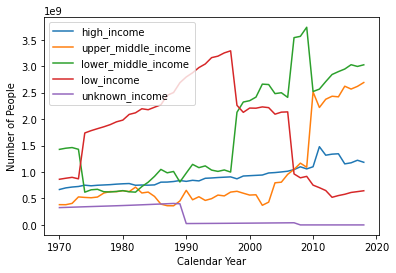

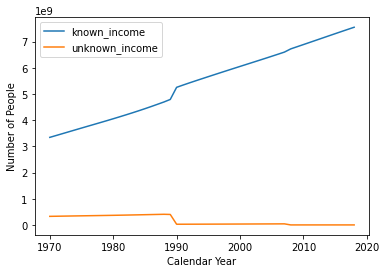

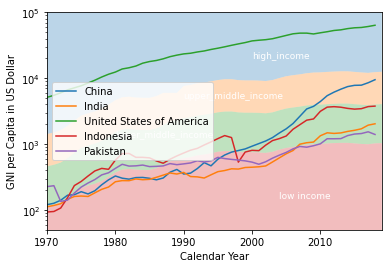

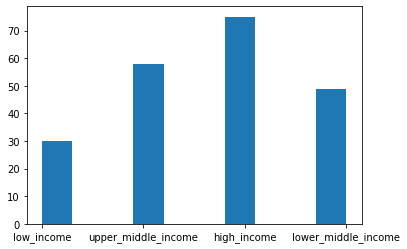

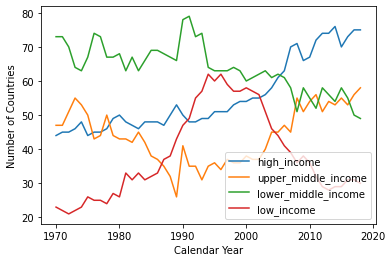

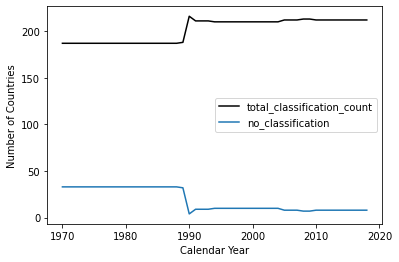

In [ ]:
#plot income classification count over time
plt.plot(population_income['high_income_population'], label = 'high_income' )
plt.plot(population_income['upper_middle_income_population'], label = 'upper_middle_income')
plt.plot(population_income['lower_middle_income_population'], label = 'lower_middle_income')
plt.plot(population_income['low_income_population'], label = 'low_income')
plt.plot(population_income['unknown_income_population'], label = 'unknown_income')
plt.xlabel('Calendar Year')
plt.ylabel('Number of People')
plt.legend()
plt.show()

#plot known / unknown classification count over time
plt.plot((population_income['total_population']-population_income['unknown_income_population']), label = 'known_income' )
plt.plot(population_income['unknown_income_population'], label = 'unknown_income')
plt.xlabel('Calendar Year')
plt.ylabel('Number of People')
plt.legend()
plt.show()

#plot income of the 5 lagrgest countries in 2018
countries_most_populous = income_classification_data.loc[2018].nlargest(5,'population_total')['country_name'].values
years = range(1970,2020)
high_income_treshold = threshold_data_complete[threshold_data_complete.index.isin(years)]['high_income_level_threshold'].values
middle_income_treshold = threshold_data_complete[threshold_data_complete.index.isin(years)]['middle_income_level_threshold'].values
low_income_treshold = threshold_data_complete[threshold_data_complete.index.isin(years)]['low_income_level_threshold'].values

fig, ax = plt.subplots()
for i in range(5):
  ax.plot(income_classification_data['gni_per_capita_us_dollar'].loc[income_classification_data['country_name']==countries_most_populous[i]],label = countries_most_populous[i])

plt.yscale('log')

ax.fill_between(years,high_income_treshold,1e5,alpha=0.3)
ax.fill_between(years,high_income_treshold, middle_income_treshold,alpha=0.3)
ax.fill_between(years,low_income_treshold, middle_income_treshold,alpha=0.3)
ax.fill_between(years,low_income_treshold,0, alpha=0.3)
ax.text(2004, 1.5e2, 'low income', fontsize=9, color = 'White')
ax.text(1980, 1.3e3, 'lower_middle_income', fontsize=9, color = 'White')
ax.text(1990, 5e3, 'upper_middle_income', fontsize=9, color = 'White')
ax.text(2000, 2e4, 'high_income', fontsize=9, color = 'White')

ax.set_xlabel('Calendar Year')
ax.set_ylabel('GNI per Capita in US Dollar')
plt.xlim([1970,2019])
plt.ylim([5e1,1e5])
plt.legend()
plt.show()


#show histogram of differtent income levels in 2018
income_classification_data['income_level_label'].loc[2018].hist( grid=False)
plt.show() 

# income_classification_data =  income_classification_data.loc[income_classification_data['population_total'] > 1000000.0]
# print(income_classification_data)
# print(income_classification_data[['population_total', 'income_level_label']].groupby(['calendar_year', 'income_level_label']).sum().groupby('calendar_year').sum())

#create df to show the sum of coutries for each income classification
income_classification_count = income_classification_data['income_level_label'].groupby('calendar_year').value_counts(dropna = False)

#plot income classification count over time [sum of countries]
plt.plot(income_classification_count[:,'high_income'], label = 'high_income' )
plt.plot(income_classification_count[:,'upper_middle_income'], label = 'upper_middle_income')
plt.plot(income_classification_count[:,'lower_middle_income'], label = 'lower_middle_income')
plt.plot(income_classification_count[:,'low_income'], label = 'low_income')
plt.xlabel('Calendar Year')
plt.ylabel('Number of Countries')
plt.legend()
plt.show()

#plot total count of classification entries each year [sum of countries]
income_classification_total_count = income_classification_count[:,'high_income']+income_classification_count[:,'upper_middle_income']+income_classification_count[:,'lower_middle_income']+income_classification_count[:,'low_income']
plt.plot(income_classification_total_count, label = 'total_classification_count', color = 'black')
plt.plot(income_classification_count[:,np.nan], label = 'no_classification')
plt.xlabel('Calendar Year')
plt.ylabel('Number of Countries')
plt.legend()
plt.show()


## World Map Visualtisation (Choropleth Map)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


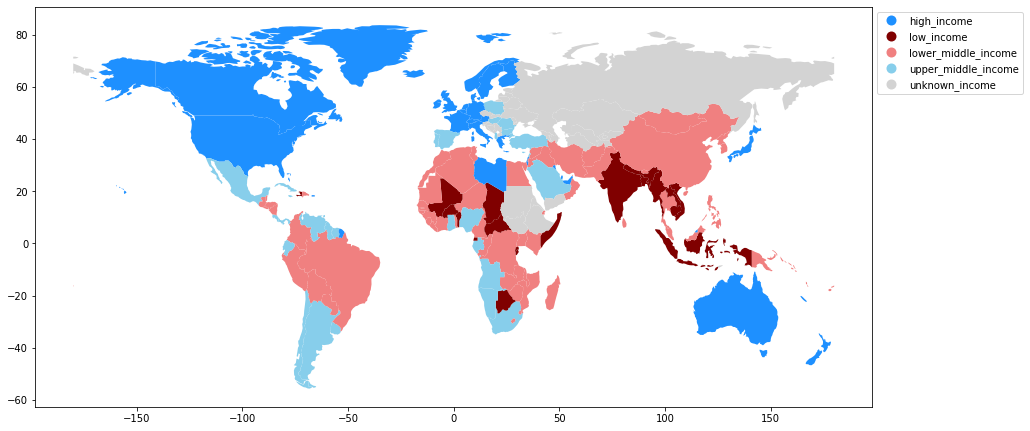

In [ ]:
#load geometry data for all countries 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#correct wrong iso code
world['iso_a3'].loc[world['name'] == 'France'] = 'FRA'
world['iso_a3'].loc[world['name'] == 'Norway'] = 'NOR'
world['iso_a3'].loc[world['name'] == 'Kosovo'] = 'XKX'

#drop unnecessary columns
country_shapes = world[['geometry', 'iso_a3']]

#merge geometry with income data on country code, select year to look at
geo_income_data = country_shapes.merge(income_classification_data.loc[1970], left_on='iso_a3', right_on='iso_alpha3_code')

#plot map
legend_dict = {'bbox_to_anchor' : (1., 1), 'loc' :'upper left'}
missing_dict = {"color": "lightgrey","label": "unknown_income"}
colors = ['dodgerblue','maroon','lightcoral','skyblue']
geo_income_data.plot(column='income_level_label', legend = True, legend_kwds = legend_dict, figsize=(15, 10), missing_kwds = missing_dict, cmap = matplotlib.colors.ListedColormap(colors))

